## Task 0: import data

1. Create folder called data next to main.ipynb
1. Create file called .gitignore next to main.ipynb. In this write: data/
1. Download data between 01-01-2021 and 01-01-2022
    1. Nordpool - hourly prices in DKK
    1. Bornholm network manager - kirkeby Sose Vindpark Active Power
    1. Digital Energy Lab/Weather Observations/DMI - All streams from Bornholm
1. Place data files under /data and rename to production, prices, and weather

## Task 1: Optimization model

In [28]:
import gurobipy as gp
import numpy as np
from gurobipy import GRB

# Create optimization model for bidding strategy in DA and balancing market
def market_bid(lambda_DA, lambda_up, lambda_down, P_proj,  C = 6500):

    T = len(P_proj)

    #### Create model ####
    m = gp.Model("market_bid")

    #### Decision variables ####
    # Production/bid in DA market
    P_hat = m.addVars(T, lb = 0, ub = C, name="P")

    # Linearized balancing variables
    delta = m.addVars(T, lb = - GRB.INFINITY, ub = GRB.INFINITY, name="delta")
    delta_up = m.addVars(T, lb = 0, ub = C, name="delta_up")
    delta_down = m.addVars(T, lb = 0, ub = C, name="delta_down")

    # Set objective
    m.setObjective(gp.quicksum(lambda_DA[i] * P_hat[i] + lambda_up[i] * delta_up[i] - lambda_down[i] * delta_down[i] for i in range(T)), GRB.MAXIMIZE)

    # Add constraints for linearization of balancing variables
    m.addConstrs(delta[i] == P_proj[i] - P_hat[i]  for i in range(T))
    m.addConstrs(delta[i] == delta_up[i] - delta_down[i]  for i in range(T))

    m.setParam('OutputFlag', 0)
    m.optimize()

    if m.status == GRB.Status.OPTIMAL:
        bid = np.array([P_hat[i].x for i in range(T)])
        return bid
    else:
        print('The model is infeasible')
        return None

## Task 2: Data collection

Want to determine some features that we believe will be useful predictors of future wind power. Could be previous wind power, features of the weather, season or similar. First step is to load data

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Import and format relevant data 
# Import production data
production = pd.read_csv('data/production.csv')
production['ts'] = pd.to_datetime(production['ts']) # Convert to datetime
production = production.set_index('ts') # Set datetime as index
production = production.resample('h').mean() # Resample to hourly data
production = production.rename(columns={"kirkeby Sose Vindpark Active Power | aki_sov_effekt | 804128": "power"}) # Rename column
production = -1 * production # Change sign to positive for production

# Import weather data
weather = pd.read_csv('data/weather.csv')
weather['ts'] = pd.to_datetime(weather['ts'])
weather = weather.set_index('ts')
weather = weather.resample('h').mean()

# Import electricity prices
prices = pd.read_csv('data/prices.csv',  decimal=',')
prices['ts'] = pd.to_datetime(prices['ts'])
prices = prices.set_index('ts')


# Import balance prices
balance = pd.read_csv('./data/balance.csv', decimal=',')
balance = balance[balance["PriceArea | PriceArea | 804696"] == "DK2"]
balance['ts'] = pd.to_datetime(balance['ts'])
balance = balance.set_index('ts')
balance.drop(columns = ["PriceArea | PriceArea | 804696"], inplace = True)
balance = balance.shift(1) # Shift data one hour to align with production data


# Merge data
inputdata = pd.concat([production, weather, prices, balance], join='inner', axis=1)

# Rename columns for easier access
inputdata = inputdata.rename(columns = {
    "Observed mean humidity past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/humidity_past1h/06193 | 406576": "humidity_Hammer_Odde",
    "Observed maximum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_max_past1h/06193 | 406592" : "temp_max_Hammer_Odde",
    "Observed accumulated precipitation the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/precip_past1h/06197 | 406528": "precipitation_Nex",
    "Observed mean wind speed the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_speed_past1h/06197 | 406512": "windspeed_Nex",
    "Observed maximum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_max_past1h/06197 | 406464": "temp_max_Nex",
    "Observed mean intensity of global radiation in the latest hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/radia_glob_past1h/06193 | 406672": "global_radiation_Hammer_Odde",
    "Observed minimum temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_min_past1h/06193 | 406608": "temp_min_Hammer_Odde",
    "Observed minimum temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_min_past1h/06197 | 406480": "temp_min_Nex",
    "Observed mean temperature past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/temp_mean_past1h/06193 | 406560": "temp_mean_Hammer_Odde",
    "Observed mean temperature past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/temp_mean_past1h/06197 | 406432": "temp_mean_Nex",
    "Observed mean humidity past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/humidity_past1h/06197 | 406448": "humidity_Nex",
    "Observed mean wind speed the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_speed_past1h/06193 | 406640": "windspeed_Hammer_Odde",
    "Observed mean wind direction the past hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/wind_dir_past1h/06197 | 406496": "winddirection_Nex",
    "Observed accumulated precipitation the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/precip_past1h/06193 | 406656": "precipitation_Hammer_Odde",
    "Observed mean intensity of global radiation in the latest hour at Nex - DMI station 06197 | 9F7Q/33/4W/DMI/metObs/radia_glob_past1h/06197 | 406544": "global_radiation_Nex",
    "Observed mean wind direction the past hour at Hammer Odde Fyr - DMI station 06193 | 9F7P/7Q/XC/DMI/metObs/wind_dir_past1h/06193 | 406624": "winddirection_Hammer_Odde",
    "Nordpool Elspot Prices - hourly price DK-DK2 DKK/MWh | 9F7J/00/00/Nordpool/DK2/hourly_spot_dkk | 4820": "spotprice",
    "BalancingPowerPriceUpDKK | BalancingPowerPriceUpDKK | 804719": "lambda_up",
    "BalancingPowerPriceDownDKK | BalancingPowerPriceDownDKK | 804721" : "lambda_down"
})


Inspection shows holes in the data. Further looking into the data shows that these are typically in windows of exactly 24 hours or integer multiples of this with 0 or near 0 values. We remove these for more representative data for the model

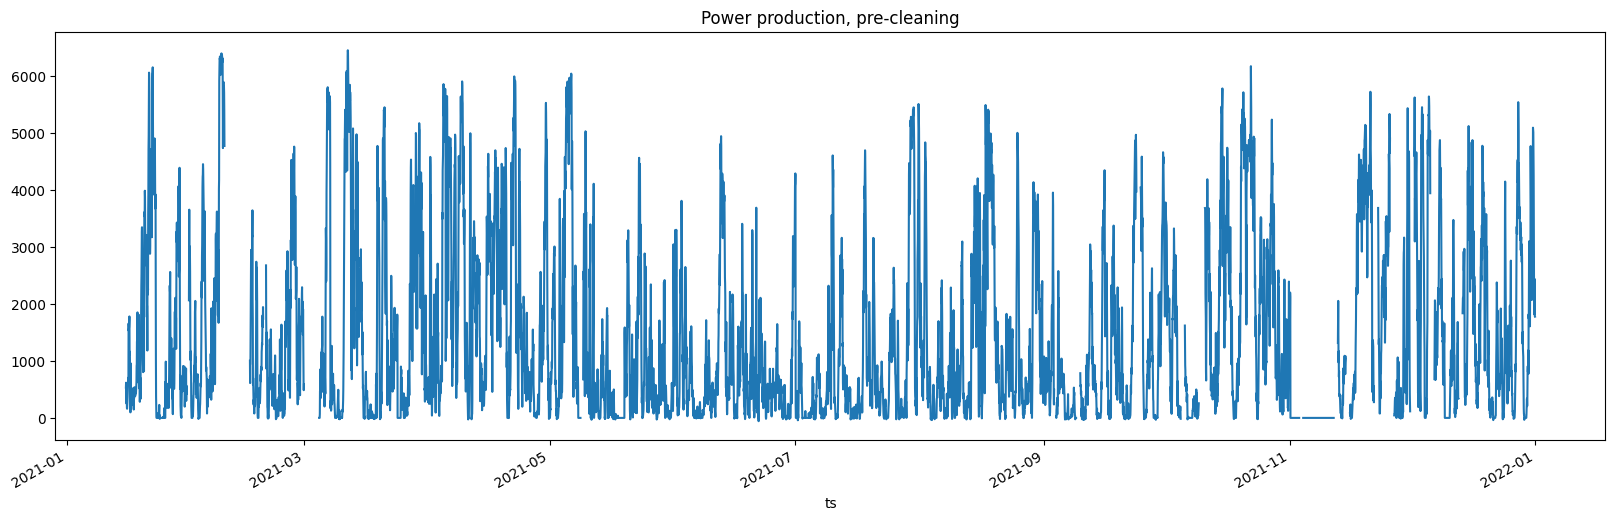

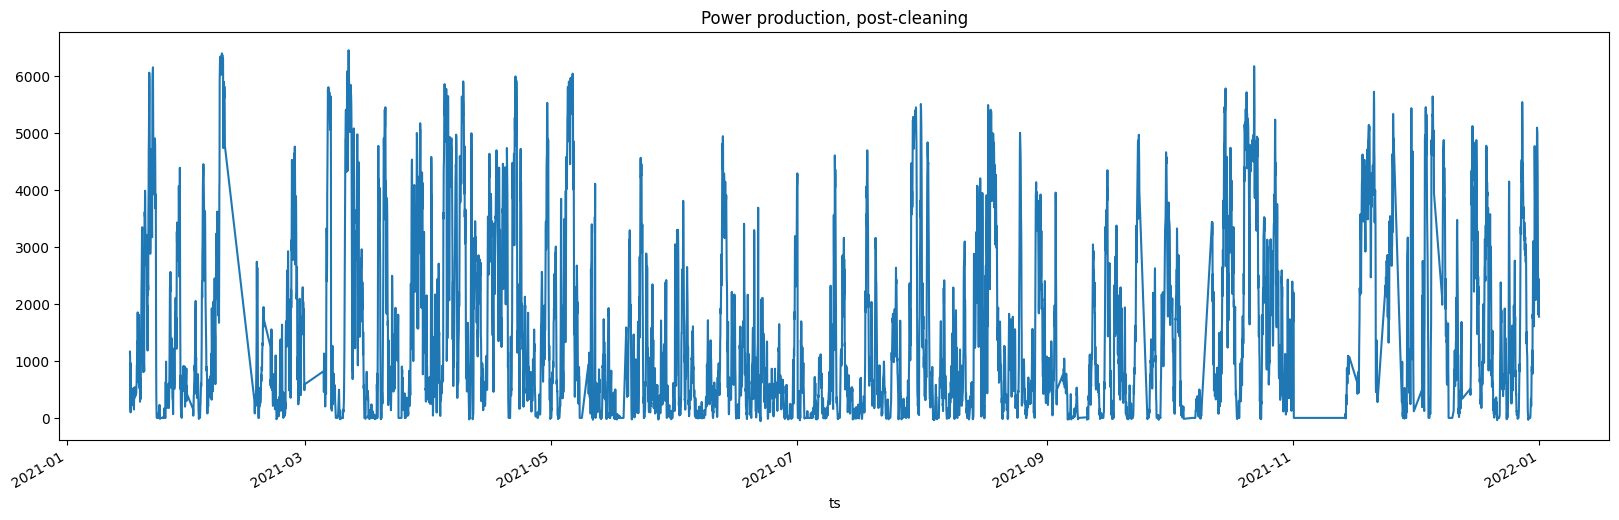

In [30]:
plt.figure(figsize=(20, 6))
inputdata["power"].plot(title = "Power production, pre-cleaning")
plt.show()

mask = inputdata["power"].rolling(window=24).sum() > 24*0.3
inputdata = inputdata.loc[mask]
plt.figure(figsize=(20, 6))
inputdata["power"].plot(title = "Power production, post-cleaning")
plt.show()

Next we add potential features

In [31]:
### Add more potential features ###
# Add hour, weekend and month as features
inputdata['hour'] = inputdata.index.hour
inputdata['weekend'] = inputdata.index.weekday > 4
inputdata['month'] = inputdata.index.month

### Add lagged power as features ###
# Add mean power production the day before as feature
daily_power = inputdata['power'].resample('D')
mean_power_lag1D = daily_power.mean().shift(1)
inputdata['mean_power_lag1D'] = inputdata.index.normalize().map(mean_power_lag1D)

# Add variance of power production the day before as feature
var_power_lag1D = daily_power.var().shift(1)
inputdata['var_power_lag1D'] = inputdata.index.normalize().map(var_power_lag1D)

### Add lagged prices as features ###
# Add mean spot price the day before as feature
daily_prices = inputdata["spotprice"].resample('D')
mean_prices_lag1D = daily_prices.mean().shift(1)
inputdata['mean_prices_lag1D'] = inputdata.index.normalize().map(mean_prices_lag1D)

# Add variance of spot price the day before as feature
var_prices_lag1D = daily_prices.var().shift(1)
inputdata['var_prices_lag1D'] = inputdata.index.normalize().map(var_prices_lag1D)

# Add spot price lagged 24 hours as feature
prices_lag24H = inputdata["spotprice"].shift(24)
inputdata['prices_lag24H'] = inputdata.index.normalize().map(prices_lag24H)

# Add mean balancing price yesterday as feature
mean_lambda_up_lag1D = inputdata["lambda_up"].resample('D').mean().shift(1)
inputdata['mean_lambda_up_lag1D'] = inputdata.index.normalize().map(mean_lambda_up_lag1D)

mean_lambda_down_lag1D = inputdata["lambda_down"].resample('D').mean().shift(1)
inputdata['mean_lambda_down_lag1D'] = inputdata.index.normalize().map(mean_lambda_down_lag1D)

# Add mean difference between spotprice and balance prices as feature
mean_diff_up_lag1D = (mean_prices_lag1D - mean_lambda_up_lag1D)
inputdata['mean_diff_up_lag1D'] = inputdata.index.normalize().map(mean_diff_up_lag1D)

mean_diff_down_lag1D = (mean_prices_lag1D - mean_lambda_down_lag1D)
inputdata['mean_diff_down_lag1D'] = inputdata.index.normalize().map(mean_diff_down_lag1D)

### Interpolate missing values and remove NaNs ###
inputdata = inputdata.interpolate()
inputdata = inputdata.dropna()

We can then check correlation of the features with the power. Correlation could indicate that the feature is useful in regression

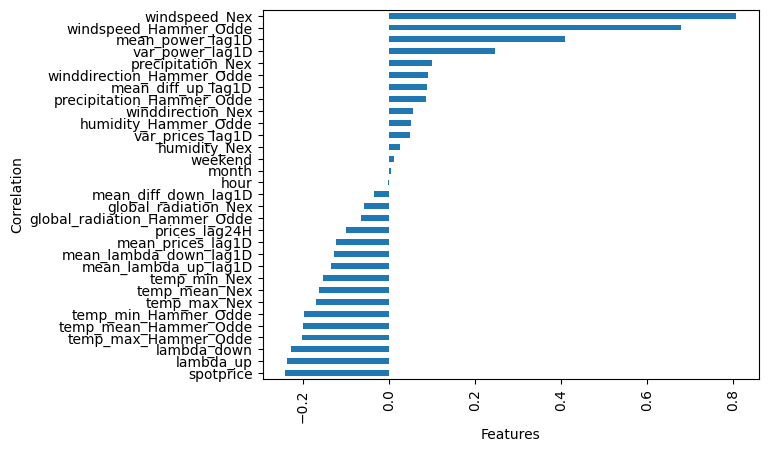

In [32]:
# Check correlation between features
inputdata.corr().iloc[1:, 0].sort_values().plot(kind='barh')
#plt.title('Correlation of "power" with other features')
plt.xlabel('Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)
plt.show()

Look closer at features with correlation > 0.2

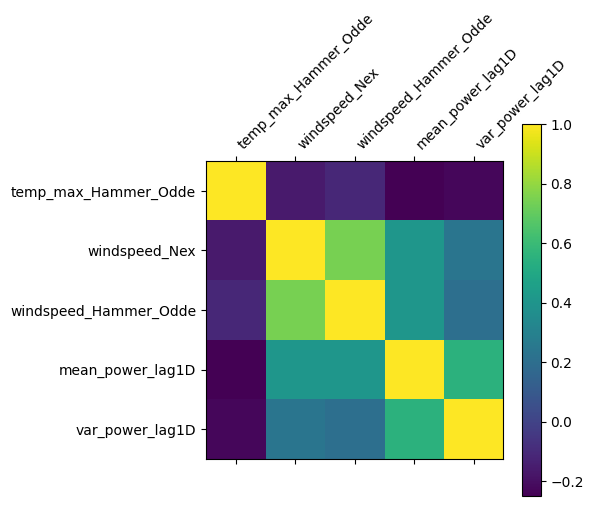

In [33]:
corr = inputdata.corr().iloc[1:, 0]
corr = corr[abs(corr) > 0.2]
features = corr.index

# Drop prices as we do not know these in advance
features = features.drop(['spotprice', 'lambda_up', 'lambda_down'])
# pd.plotting.scatter_matrix(inputdata[features], figsize=(20, 20))
# plt.show()

plt.matshow(inputdata[features].corr())
plt.xticks(range(len(features)), features, rotation=45, ha='left')
plt.yticks(range(len(features)), features, rotation=0)
plt.colorbar()
plt.show()


In [34]:
# Wind speeds are highly correlated with each other. Dropping Hammer Odde
features = features.drop("windspeed_Hammer_Odde")

# Select features with correlation > 0.2
x = inputdata[features]
y = inputdata['power'][x.index]

# Print selected features
print(x.columns)

Index(['temp_max_Hammer_Odde', 'windspeed_Nex', 'mean_power_lag1D',
       'var_power_lag1D'],
      dtype='object')


In [35]:
# Scale data using standard scaler
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Add bias term to input data
X = np.concatenate([np.ones((x.shape[0], 1)), x_scaled], axis=1)

# Split data into training and test set for time series data
test_train_fraction = 0.80
test_train_index = int(len(x) * test_train_fraction)
X_train, X_test = X[:test_train_index], X[test_train_index:]
y_train, y_test = y[:test_train_index], y[test_train_index:]

# Further split training data into training and validation data
train_validation_fraction = 0.80
train_validation_index = int(len(X_train) * train_validation_fraction)
X_train_train, X_train_val = X_train[:train_validation_index], X_train[train_validation_index:]
y_train_train, y_train_val = y_train[:train_validation_index], y_train[train_validation_index:]

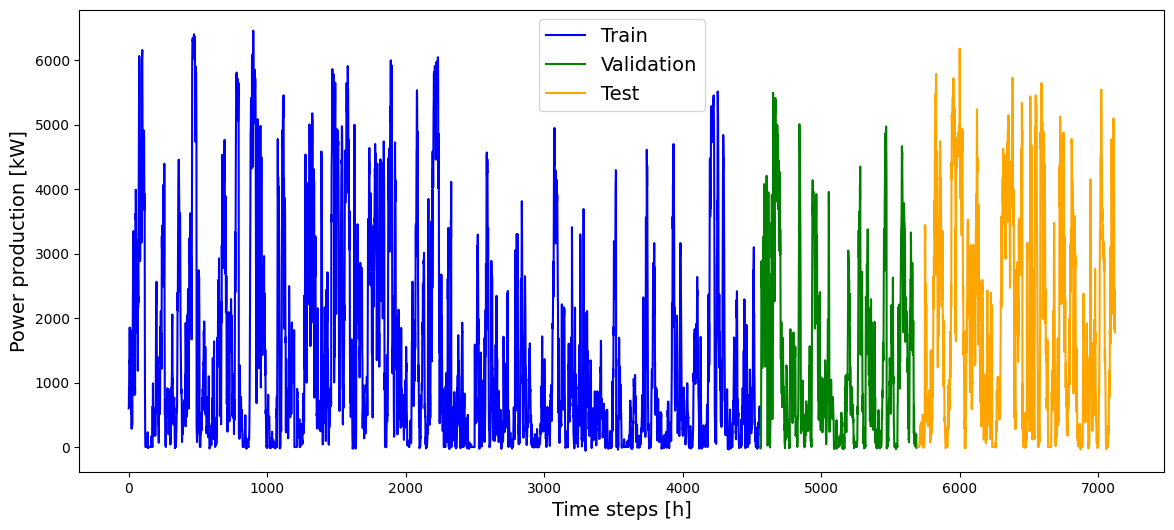

In [36]:
# Plot target variable against time, split into training and test set
plt.figure(figsize=(14, 6))
plt.plot(np.arange(len(y_train_train)), y_train_train, label='Train', color='blue')
plt.plot(np.arange(len(y_train_train), len(y_train_train)+ len(y_train_val)), y_train_val, label='Validation', color='green')
plt.plot(np.arange(len(y_train), len(y_train)+ len(y_test)), y_test, label='Test', color = 'orange')
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()

## Task 3: Linear Regression

In [37]:
# Implement gradient descent
def gradient_descent(X_train, y_train, max_iterations=10000, alpha = 0.01):
    # Initial guess of coefficients
    theta = np.zeros(X_train.shape[1])

    # Number of observations
    m = len(X_train)
    
    for _ in range(max_iterations):

        # Linear regression prediction
        h = theta @ X_train.T

        # The partial derivatives of the cost function
        dt = (1/m) * ((h - y_train.T) @ X_train)

        # Update the coefficients
        theta = theta - alpha * dt

        # Break if the change in coefficients is small
        if np.linalg.norm(alpha * dt) < 1e-6:
            return theta
        
    return theta


# Implement closed form solution
theta_cfs = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

# Compare the two solutions
print(np.round(gradient_descent(X_train, y_train),2))
print(np.round(theta_cfs,2))


[1413.38  -69.92 1167.44  130.45    6.04]
[1413.38  -69.92 1167.44  130.45    6.04]


We see that both gradient descent and the closed for solution reaches the same solution. We will typically use the closed form. We can now evaluate how accurate the model is

RMSE: 984.9
MAE: 765.3
R2: 0.65


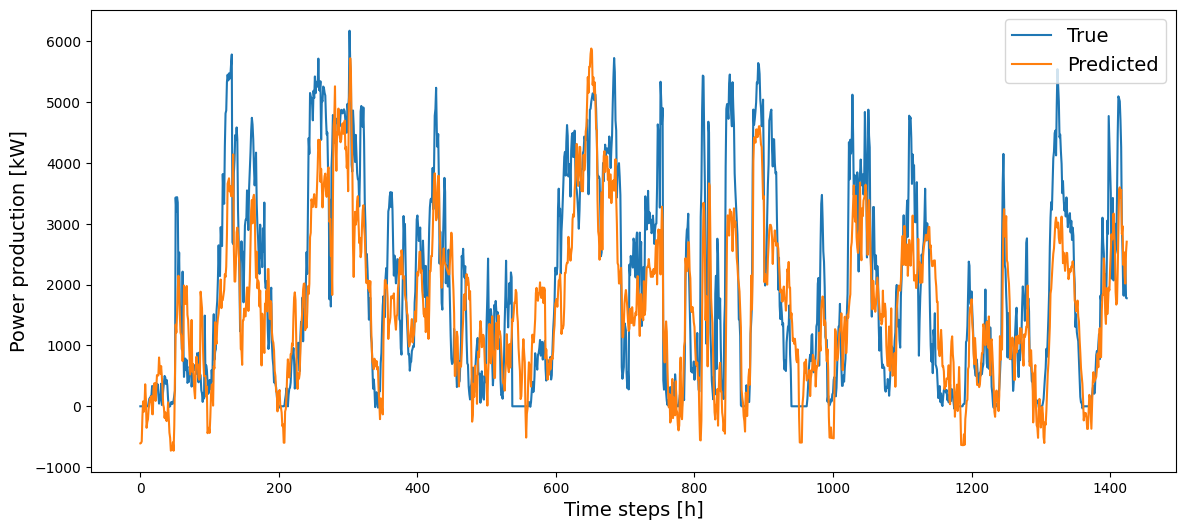

In [38]:
# Evaluate model
from sklearn.metrics import mean_absolute_error, r2_score

# Make predictions
y_OLS = X_test @ theta_cfs

# Calculate metrics
def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

rmse_OLS = rmse(y_test, y_OLS)
mae_OLS = mean_absolute_error(y_test, y_OLS)
r2_OLS = r2_score(y_test, y_OLS)

print(f"RMSE: {rmse_OLS:.1f}")
print(f"MAE: {mae_OLS:.1f}")
print(f"R2: {r2_OLS:.2f}")

# Plot predictions
test_index = np.arange(len(y_test))
plt.figure(figsize=(14, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_OLS, label='Predicted')
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()

## Task 4: Non-linear regression

The first type of non-linear regression we can make is polynomial regression. Here we can add some of the features to some power and see if this improves our predicitons. We will try with powers of the wind speed

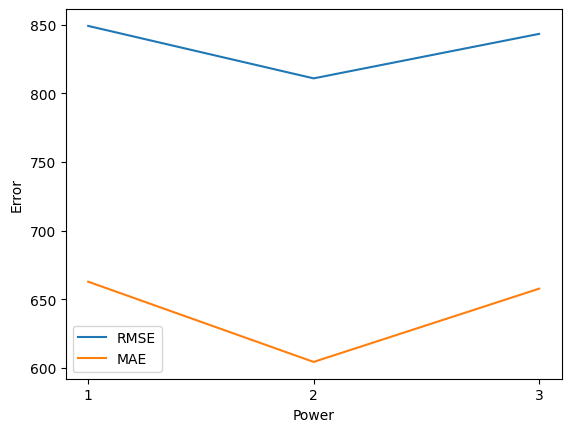

In [ ]:
rmse_vals = []
mae_vals = []
r2_vals = []
idx = 2 # Index of windspeed_Nex
power = np.arange(1, 4)

for i in power:
    # Add wind power to the power of i as feature
    x_train_poly = np.concatenate([X_train_train, np.power(X_train_train[:, idx], i).reshape(-1,1)], axis=1)
    x_val_poly = np.concatenate([X_train_val, np.power(X_train_val[:, idx], i).reshape(-1,1)], axis=1)

    # Train and predict polynomial model
    theta_poly = gradient_descent(x_train_poly, y_train_train)
    y_poly_val =  x_val_poly @ theta_poly

    # Calculate metrics
    rmse_poly = rmse(y_train_val, y_poly_val)
    mae_poly = mean_absolute_error(y_train_val, y_poly_val)
    r2_poly = r2_score(y_train_val, y_poly_val)

    rmse_vals.append(rmse_poly)
    mae_vals.append(mae_poly)
    r2_vals.append(r2_poly)

plt.plot(power, rmse_vals, label='RMSE')
plt.plot(power, mae_vals, label='MAE')
plt.legend()
plt.xlabel('Power')
plt.xticks(power)
plt.ylabel('Error')
plt.show()


We observe that a second degree polynomial is the best of the tested powers. We therefore implement this

[1229.3  -60.3 1058.9   91.7   25.5  181.3]
RMSE: 1015.4
MAE: 765.6
R2: 0.63


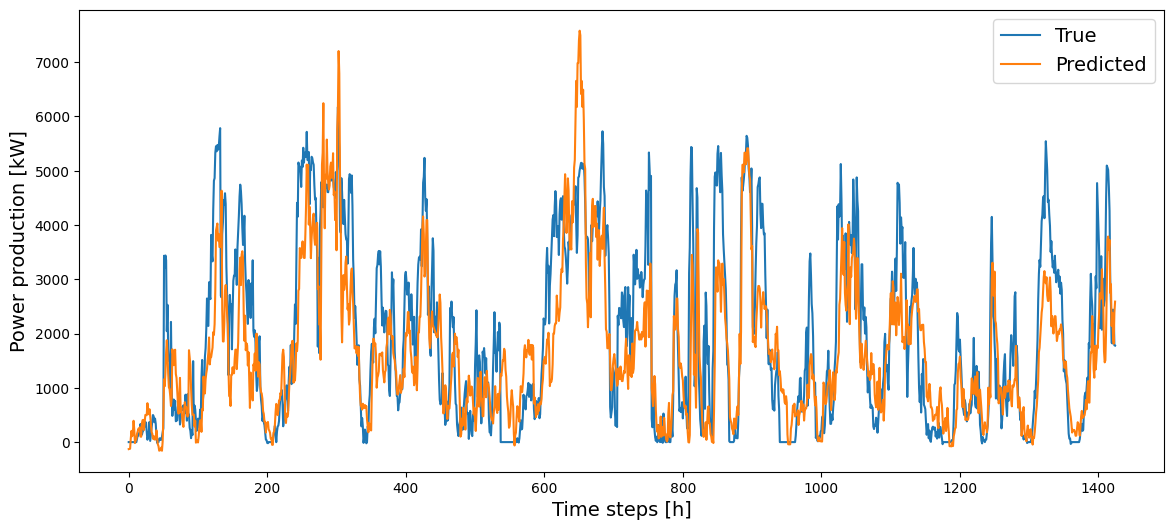

In [40]:
# 4.1: Implement polynomial regression
# Add wind speed as a second degree polynomial
x_train_poly = np.concatenate([X_train, np.power(X_train[:, 2], 2).reshape(-1,1)], axis=1)
x_val_poly = np.concatenate([X_train_val, np.power(X_train_val[:, 2], 2).reshape(-1,1)], axis=1)
x_test_poly = np.concatenate([X_test, np.power(X_test[:, 2], 2).reshape(-1,1)], axis=1)

# Train and predict polynomial model
theta_poly = np.linalg.inv(x_train_poly.T @ x_train_poly) @ x_train_poly.T @ y_train
y_poly = x_test_poly @ theta_poly
print(np.round(theta_poly,1))

# Calculate metrics
rmse_poly = rmse(y_test, y_poly)
mae_poly = mean_absolute_error(y_test, y_poly)
r2_poly = r2_score(y_test, y_poly)

print(f"RMSE: {rmse_poly:.1f}")
print(f"MAE: {mae_poly:.1f}")
print(f"R2: {r2_poly:.2f}")


plt.figure(figsize=(14, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_poly, label='Predicted')
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()


Next we can try to implement locally weighted regression. Here the model will be fitted on weighted training data. The weights are adjusted based on some kernel that typically puts more weight on training points close to our test point. Since the model is locally weighted, each point in the test set results in a new local regressions and this method therefore takes quite some time to run. First we define useful functions

In [41]:
# Possible kernels
def gaussian(t):
    return np.exp(-0.5 * t**2) / np.sqrt(2 * np.pi)

def epanechnikov(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 0.75 * (1 - t[np.abs(t) <= 1]**2)
    return kern

def tricube(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = (70 / 81) * (1 - np.abs(t[np.abs(t) <= 1])**3)**3
    return kern

def uniform(t, p=0.2):
    return np.zeros_like(t) + p

def triangle(t):
    kern = np.zeros_like(t)
    kern[np.abs(t) <= 1] = 1 - np.abs(t[np.abs(t) <= 1])
    return kern


# Implement locally weighted least squares
def lwls(X_train, y_train, X_test, kernel=gaussian, bandwidth=0.1):
    y_pred = np.zeros(X_test.shape[0])
    for i, x in enumerate(X_test):
        # Calculate weights
        weights = kernel(np.linalg.norm(X_train - x, axis=1) / bandwidth)
        W = np.diag(weights)
        
        # Calculate theta
        theta = np.linalg.inv(X_train.T @ W @ X_train) @ X_train.T @ W @ y_train
        
        # Make prediction
        y_pred[i] = x @ theta
        
    return y_pred

# Test out different bandwidths
def bandwidth_tuning(X_train, y_train, X_val, y_val, kernel, bandwidths):
    rmse_vals = []
    mae_vals = []
    
    for bandwidth in bandwidths:
        # Generate predictions with current bandwidth
        y_pred = lwls(X_train, y_train, X_val, kernel=kernel, bandwidth=bandwidth)
        
        # Calculate error metrics
        rmse_vals.append(rmse(y_val, y_pred))
        mae_vals.append(mean_absolute_error(y_val, y_pred))
    
    # Plot RMSE and MAE against bandwidths
    plt.plot(bandwidths, rmse_vals, label='RMSE')
    plt.plot(bandwidths, mae_vals, label='MAE')
    plt.xlabel('Bandwidth')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'Bandwidth tuning for {kernel.__name__} kernel')
    plt.show()

    # Identify the best bandwidth
    best_idx = np.argmin(np.mean([rmse_vals, mae_vals], axis=0))
    best_bandwidth = bandwidths[best_idx]
    best_rmse = rmse_vals[best_idx]
    best_mae = mae_vals[best_idx]
    
    # Print the RMSE and MAE for the best bandwidth
    print(f"Best bandwidth: {best_bandwidth}")
    print(f"RMSE at best bandwidth: {best_rmse:.3f}")
    print(f"MAE at best bandwidth: {best_mae:.3f}")
    
    # Return best bandwidth according to the mean of RMSE and MAE
    best_bandwidth = bandwidths[np.argmin(np.mean([rmse_vals, mae_vals], axis=0))]
    return best_bandwidth, best_rmse, best_mae

We can then determine the best bandwidth based on the training and validation sets. We can do that for multiple kernels, but have tested and found the tricube to be the best.

In [ ]:
# Bandwidth tuning
bandwidths = np.linspace(2, 10, 10)  # Linear-spaced bandwidths from 1 to 10

# opt_bandwidth = bandwidth_tuning(X_train_train, y_train_train, X_train_val, y_train_val, kernel=gaussian, bandwidths=bandwidths)
#print("Best bandwidth for Gaussian kernel:", opt_bandwidth)

#opt_bandwidth = bandwidth_tuning(X_train_train, y_train_train, X_train_val, y_test, kernel=epanechnikov, bandwidths=bandwidths)
#print("Best bandwidth for Epanechnikov kernel:", opt_bandwidth)

opt_bandwidth = bandwidth_tuning(X_train_train, y_train_train, X_train_val, y_train_val, kernel=tricube, bandwidths=bandwidths)
# print("Best bandwidth for Tricube kernel:", opt_bandwidth[0])

#opt_bandwidth = bandwidth_tuning(X_train_train, y_train_train, X_train_val, y_test, kernel=uniform, bandwidths=bandwidths)
#print("Best bandwidth for Uniform kernel:", opt_bandwidth)

#opt_bandwidth = bandwidth_tuning(X_train_train, y_train_train, X_train_val, y_test, kernel=triangle, bandwidths=bandwidths)
#print("Best bandwidth for Triangle kernel:", opt_bandwidth)

KeyboardInterrupt: 

With the kernel and bandwidth in place, we will fit the defined model.

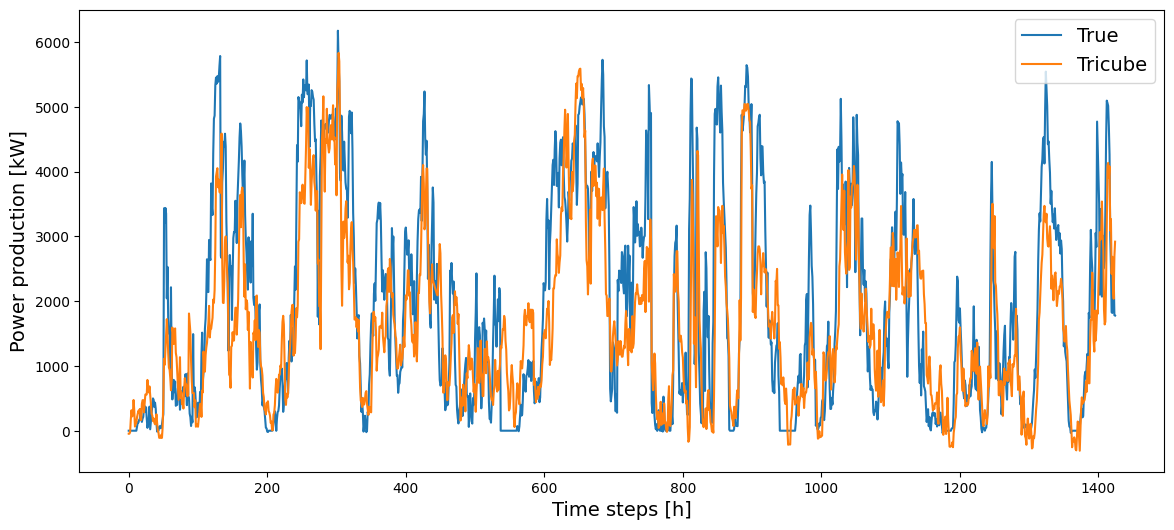

Tricube: 
RMSE: 974.2
MAE: 737.3
R2: 0.66


In [51]:
# Make predictions
band = opt_bandwidth[0]

y_lwls_tricube = lwls(X_train, y_train, X_test, kernel=tricube, bandwidth=band)


# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index , y_lwls_tricube, label='Tricube')
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()


rmse_local_tricube = rmse(y_test, y_lwls_tricube)
mae_local_tricube = mean_absolute_error(y_test, y_lwls_tricube)
r2_local_tricube = r2_score(y_test, y_lwls_tricube)

print("Tricube: ")
print(f"RMSE: {rmse_local_tricube:.1f}")
print(f"MAE: {mae_local_tricube:.1f}")
print(f"R2: {r2_local_tricube:.2f}")


## Task 5: Regularization

We can now try and fit regularization on our model. First we define a method for tuning the strength of the regularization

In [52]:
from sklearn.linear_model import Lasso, Ridge

def regularization_tuning(X_train, y_train, X_val, y_val, method, gammas):
    rmse_val = []
    mae_val = []
    for gamma in gammas:
        if method == 'Lasso':
            reg = Lasso(gamma)
        elif method == 'Ridge':
            reg = Ridge(gamma)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_val)
        rmse_val.append(rmse(y_val, y_pred))
        mae_val.append(mean_absolute_error(y_val, y_pred))
    
    
    plt.plot(gammas, rmse_val, label='RMSE')
    plt.plot(gammas, mae_val, label='MAE')
    plt.xscale('log')
    plt.xlabel('gamma')
    plt.ylabel('Error')
    plt.legend()
    plt.title(f'{method} regularization tuning')
    plt.show()

    # Return best alpha according to mean of RMSE and MAE
    best_alpha = gammas[np.argmin(np.mean([rmse_val, mae_val], axis=0))]
    return best_alpha

We can then determine the best strength based on the validation set

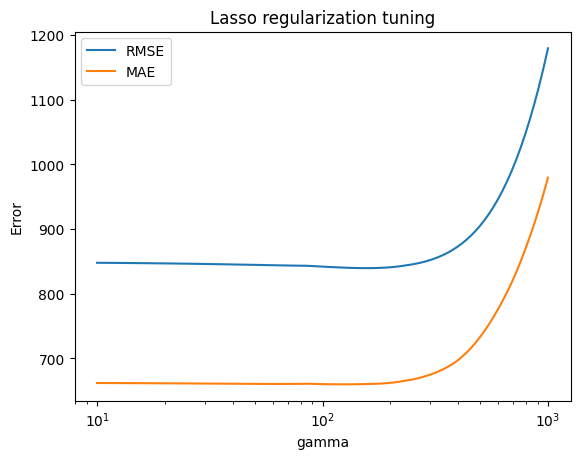

Optimal alpha for lasso: 141.7


In [53]:
gammas = np.logspace(1, 3, 100)
opt_gamma_lasso = regularization_tuning(X_train_train, y_train_train, X_train_val, y_train_val, 'Lasso', gammas)
print(f'Optimal alpha for lasso: {opt_gamma_lasso:.1f}')

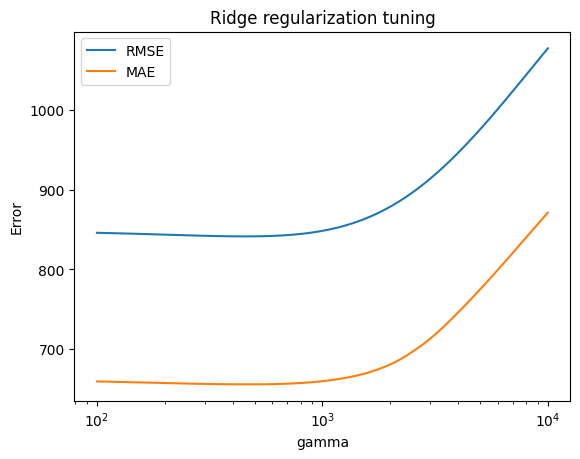

Optimal alpha for ridge: 443.1


In [54]:
gammas = np.logspace(2, 4, 100)
opt_gamma_ridge = regularization_tuning(X_train_train, y_train_train, X_train_val, y_train_val, 'Ridge', gammas)
print(f'Optimal alpha for ridge: {opt_gamma_ridge:.1f}')

The models are now implemented with the determined strengths

RMSE Lasso: 1039.4
MAE Lasso: 803.2
R2 Lasso: 0.61
[   0.    -0.  1073.7   42.3    0. ]
RMSE Ridge: 1002.8
MAE Ridge: 777.4
R2 Ridge: 0.64
[   0.   -76.9 1069.9  149.6   15.6]


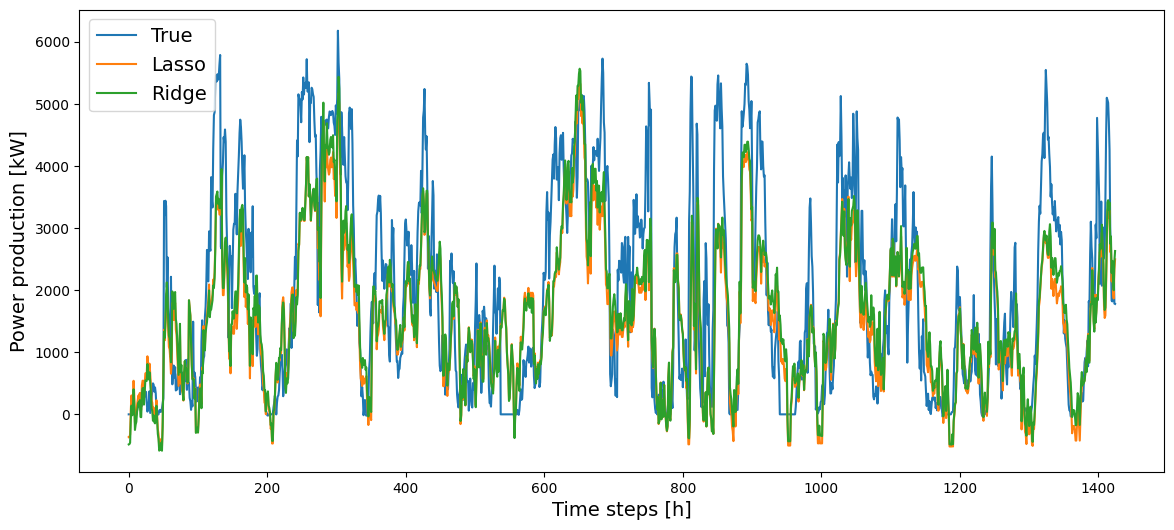

In [55]:
# Implement Lasso regression
lasso = Lasso(alpha=opt_gamma_lasso)
lasso.fit(X_train, y_train)
y_lasso = lasso.predict(X_test)

# Implement Ridge regression
ridge = Ridge(alpha=opt_gamma_ridge)
ridge.fit(X_train, y_train)
y_ridge = ridge.predict(X_test)

# Evaluate models
rmse_lasso = rmse(y_test, y_lasso)
mae_lasso = mean_absolute_error(y_test, y_lasso)
r2_lasso = r2_score(y_test, y_lasso)

rmse_ridge = rmse(y_test, y_ridge)
mae_ridge = mean_absolute_error(y_test, y_ridge)
r2_ridge = r2_score(y_test, y_ridge)

print(f"RMSE Lasso: {rmse_lasso:.1f}")
print(f"MAE Lasso: {mae_lasso:.1f}")
print(f"R2 Lasso: {r2_lasso:.2f}")
print(lasso.coef_.round(1))

print(f"RMSE Ridge: {rmse_ridge:.1f}")
print(f"MAE Ridge: {mae_ridge:.1f}")
print(f"R2 Ridge: {r2_ridge:.2f}")
print(ridge.coef_.round(1))

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(test_index, y_test, label='True')
plt.plot(test_index, y_lasso, label='Lasso')
plt.plot(test_index, y_ridge, label='Ridge')
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()


As expected, the lasso regularization sets some of the coefficients to 0, while Ridge shrinks some of the coefficients. We can now create a new dataframe to save all our models and relevant data for evaluating them

In [56]:
# Create dataframe with test data and predictions
model_names = ['OLS', 'poly', 'y_lwls_tricube', 'Lasso', 'Ridge']
projections = pd.DataFrame({'OLS': y_OLS, 'poly': y_poly, 'y_lwls_tricube': y_lwls_tricube, 'Lasso': y_lasso, 'Ridge': y_ridge}, index=y_test.index)
test_data = pd.concat([y_test, inputdata[["spotprice", "lambda_down", "lambda_up"]], projections], axis=1, join='inner')

## Task 6: Revenue calculation for evaluation

Currently the true prices are loaded, but these are unknow to us during our bid optimization. In reality these must also be predicted. This is not a focus of ours, and we implement a very simple linear model using date information and wind speed at Nexø. The wind speed is in reality also uncertain and relies on predictions, but we will here assume that the people at DMI are very competent and the wind speed predictions are correct.

In [57]:
from sklearn.linear_model import LinearRegression

X = inputdata["windspeed_Nex"].to_frame()
X['hour'] = X.index.hour
X["weekend"] = X.index.weekday > 4
X = pd.get_dummies(X, columns=["hour", "weekend"]) 
train, test = X.iloc[:test_train_index], X.iloc[test_train_index:]

# Fit linear regression models
predicted_prices = pd.DataFrame(index = test.index)
for price in ["spotprice", "lambda_down", "lambda_up"]:
    y = inputdata[inputdata.index.isin(train.index)][price]
    model = LinearRegression()
    model.fit(train, y)
    predicted_prices[price] = model.predict(test)


We can now get an idea of how similar the predictions are by plotting them together with the true power production

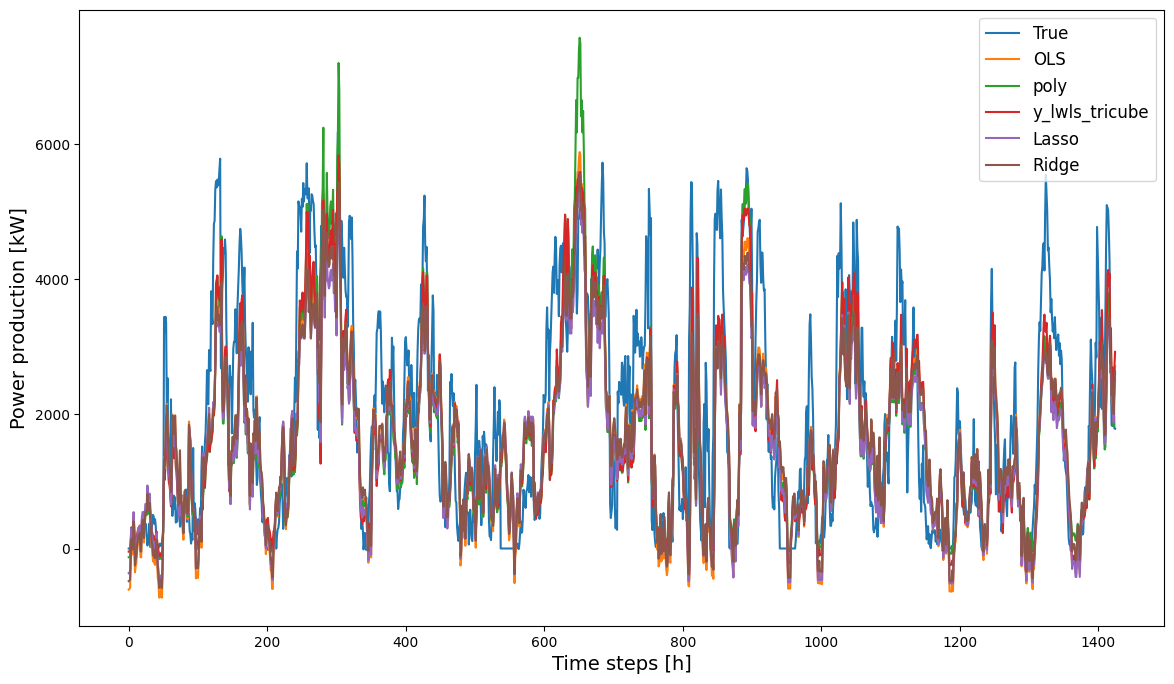

In [61]:
# Plot all predictions together with test data
plt.figure(figsize=(14, 8))
plt.plot(test_index, test_data['power'], label='True')
plt.plot(test_index, test_data['OLS'], label='OLS')
plt.plot(test_index, test_data['poly'], label='poly')
plt.plot(test_index, test_data['y_lwls_tricube'], label='y_lwls_tricube')
plt.plot(test_index, test_data['Lasso'], label='Lasso')
plt.plot(test_index, test_data['Ridge'], label='Ridge')
plt.legend(fontsize=12, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()

We can now feed the model predictions of power and prices to our optimizer to get our bids. The revenue can then be computed with the bids and true power and prices

In [62]:
def revenue(test_data, predicted_prices, projection):
    real = test_data["power"].values
    lambda_DA = test_data["spotprice"].values
    lambda_up = test_data["lambda_up"].values
    lambda_down = test_data["lambda_down"].values

    bid = market_bid(predicted_prices["spotprice"], predicted_prices["lambda_up"], predicted_prices["lambda_down"], projection)
    rev = np.sum(bid * lambda_DA + lambda_down * np.maximum(real - bid, 0) - lambda_up * np.maximum(bid - real, 0))
    return rev, bid


revenues = pd.DataFrame(index = [1], columns=model_names)
bids_m1 = pd.DataFrame(index = np.arange(len(test_data)), columns=model_names)


for model in model_names:
    revenues[model], bids_m1[model] = revenue(test_data, predicted_prices, test_data[model].values)

revenues

Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-10


C:\Users\jacob\AppData\Local\Temp\ipykernel_4628\1738007286.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  m.setObjective(gp.quicksum(lambda_DA[i] * P_hat[i] + lambda_up[i] * delta_up[i] - lambda_down[i] * delta_down[i] for i in range(T)), GRB.MAXIMIZE)


,OLS,poly,y_lwls_tricube,Lasso,Ridge
1,1.931853e+09,1.929021e+09,1.931651e+09,1.927136e+09,1.929139e+09


We can take a look at how the bids look like

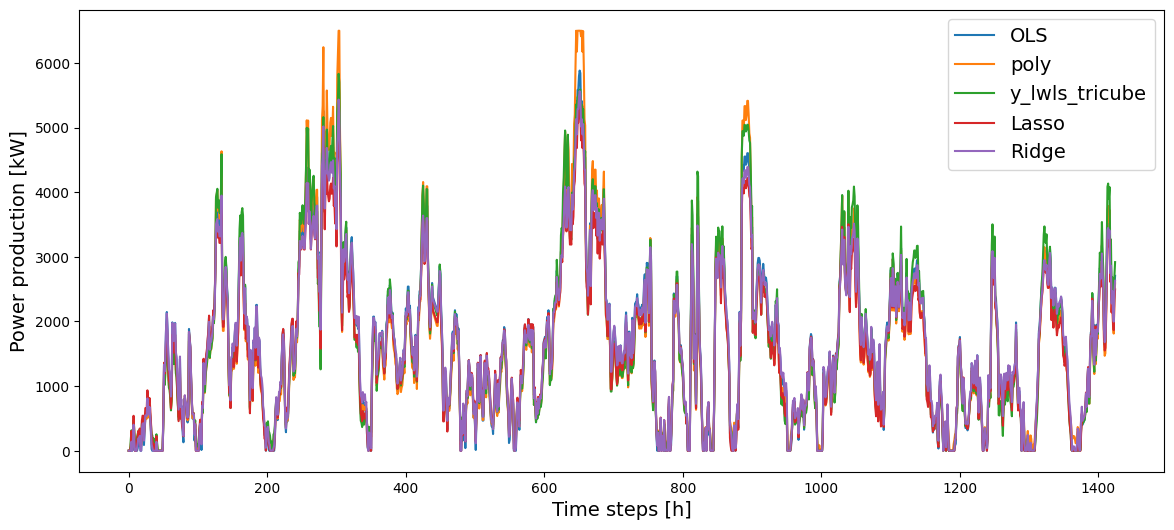

In [63]:
# Plot bids from models
plt.figure(figsize=(14, 6))
for model in model_names:
    plt.plot(bids_m1[model], label=model)
plt.legend(fontsize=14, loc = 'best')
plt.xlabel('Time steps [h]', fontsize=14)
plt.ylabel('Power production [kW]', fontsize=14)
plt.show()

And how the distribution of the bids look like

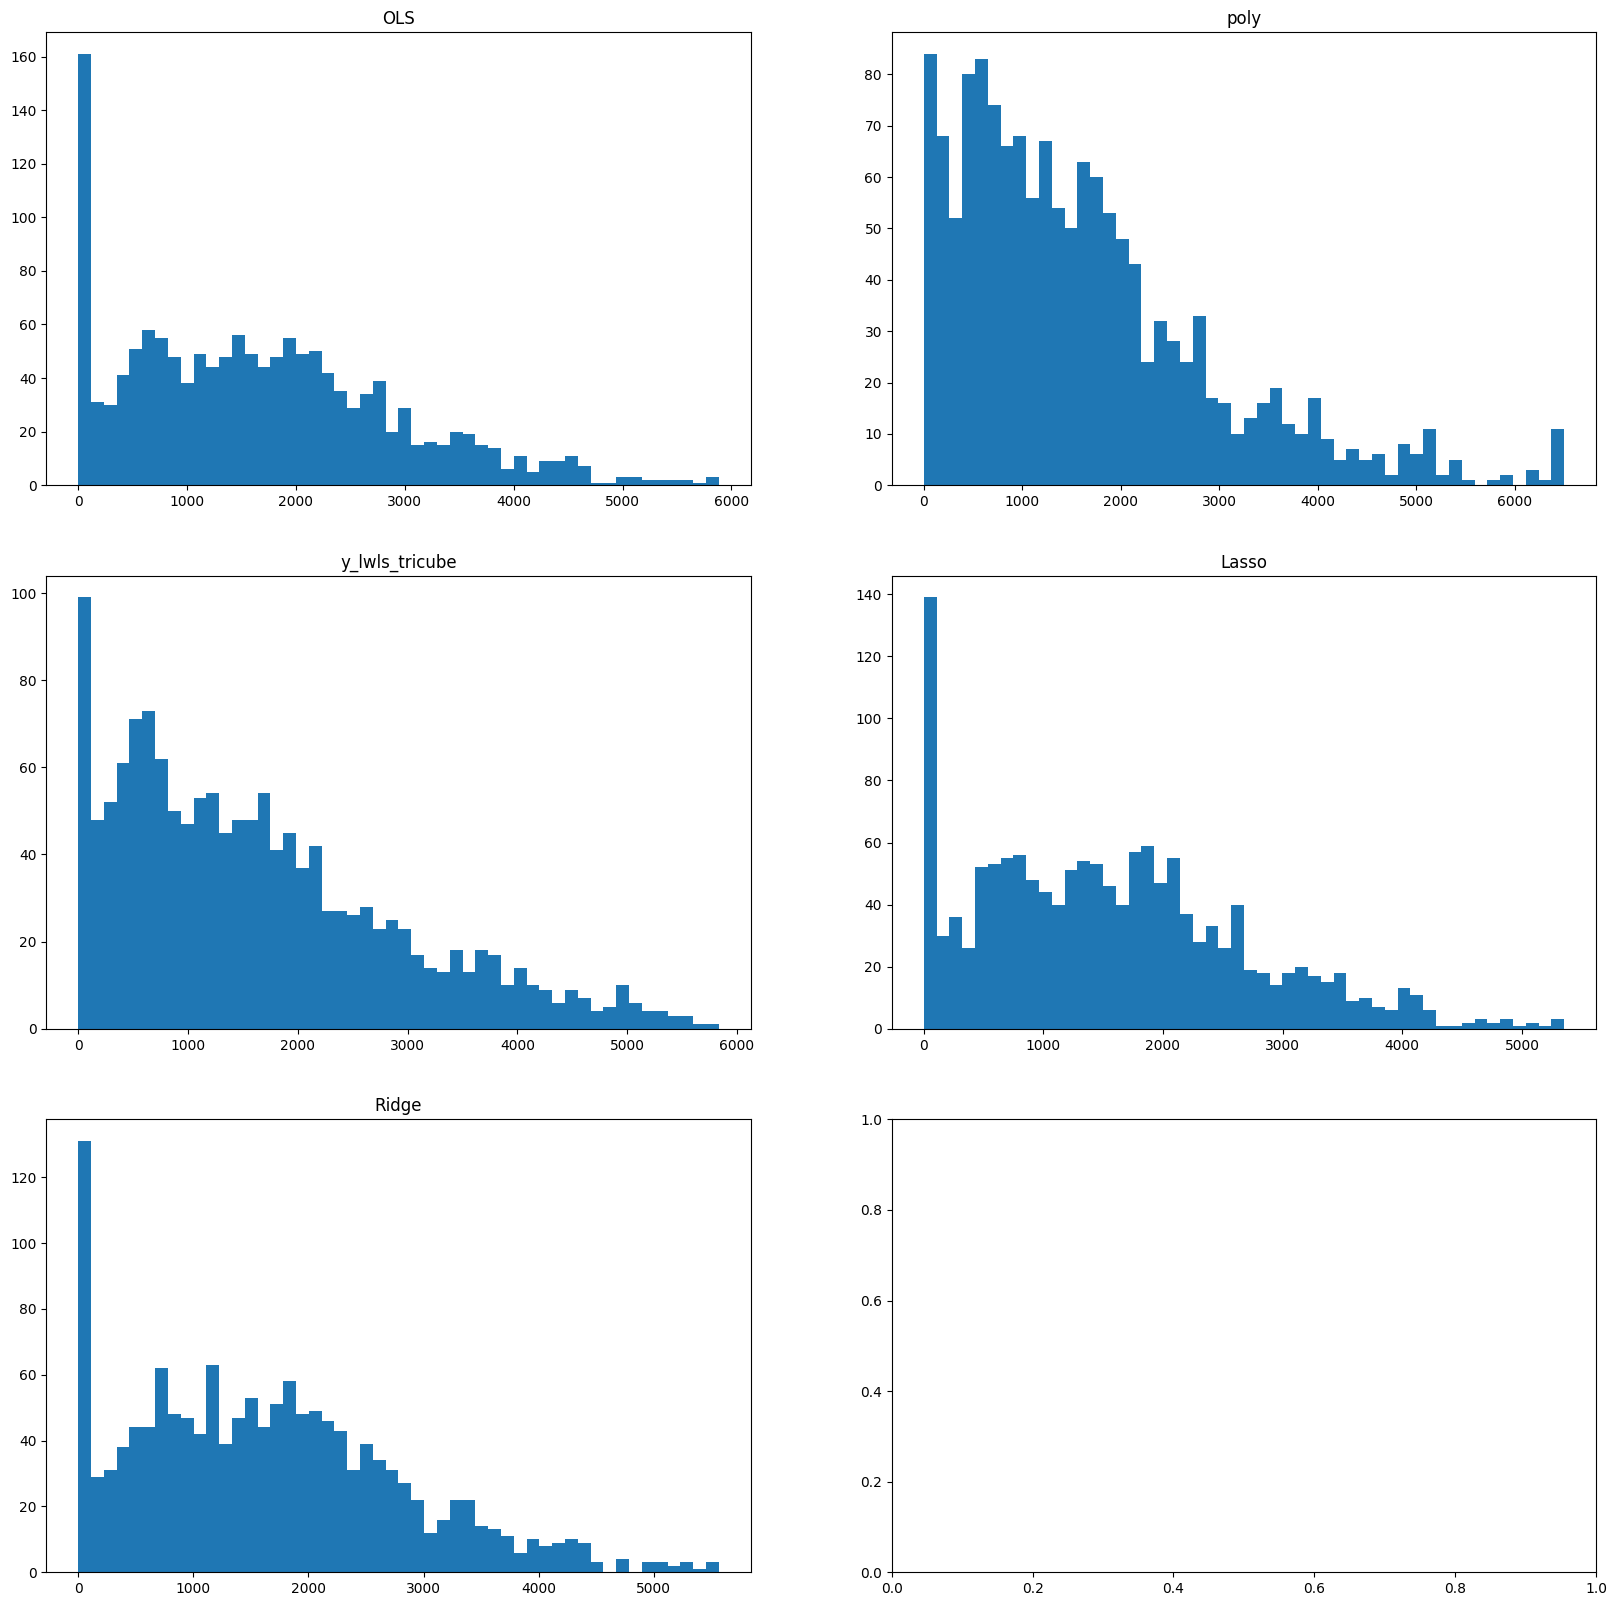

In [64]:
# Plot historgam of bids for each model in seperate subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 20))
for i, model in enumerate(model_names):
    axs[i//2, i%2].hist(bids_m1[model], bins=50)
    axs[i//2, i%2].set_title(model)
plt.show()


## Task 8: Model 2
Predict power bids. First we find the optimal bids if we had perfect foresight. This is used for training model 2

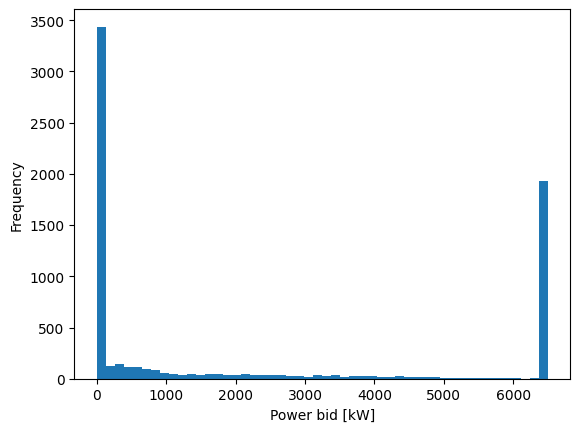

In [65]:
bids = market_bid(inputdata["spotprice"].values, inputdata["lambda_up"].values, inputdata["lambda_down"].values, inputdata["power"].values)
plt.hist(bids, bins = 50)
# plt.title("Optimal bids with perfect foresight")
plt.xlabel("Power bid [kW]")
plt.ylabel("Frequency")
plt.show()

We can now check for any correlation between our bids and possible features

<Axes: >

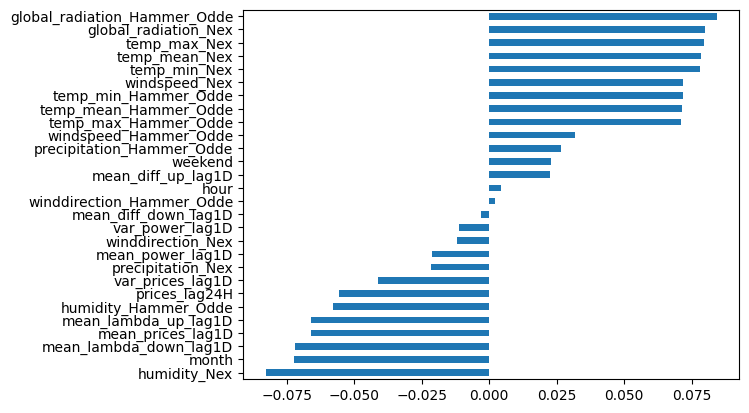

In [66]:
# Add optimal bids to inputdata
inputdata['opt_bids'] = bids

# Check correlation between features and optimal bids for relevant features
bid_features = inputdata.columns.drop(['power', 'spotprice', 'lambda_up', 'lambda_down'])

inputdata[bid_features].corr().loc["opt_bids"].drop("opt_bids").sort_values().plot(kind='barh')

There are no clear correlation to find. Instead we try to include date features

In [67]:
y = inputdata['opt_bids']

# Keep only time features in x and replace hour, month, and weekend columns with one-hot encoding
x = inputdata[['hour', 'month', 'weekend']]
x = pd.get_dummies(x, columns=['hour', 'month', 'weekend'], drop_first=True)

As the histogram of the bids appeared to follow a all or nothing approach, we will try with a classifier. Here a decision tree is used. We must therefore convert our target to a class. Here we split at half the capacity and use this to determine whether to bid all or nothing

In [68]:
# Split into training and test set
training_test_fraction = 0.8

# Make target binary for classification
y_bin = y > 3750

split_index_test = int(len(x) * training_test_fraction)
x_train, x_test = x[:split_index_test], x[split_index_test:]
y_train, y_test = y_bin[:split_index_test], y_bin[split_index_test:]

train_validation_fraction = 0.8
split_index_val = int(len(x_train) * train_validation_fraction)
x_train_train, x_train_val = x_train[:split_index_val], x_train[split_index_val:]
y_train_train, y_train_val = y_train[:split_index_val], y_train[split_index_val:]

Accuracy: 0.67
Perfect revenue: 2.04 MDKK
Predicted revenue using decision tree: 1.75 MDKK
Difference in revenue: 0.29 MDKK


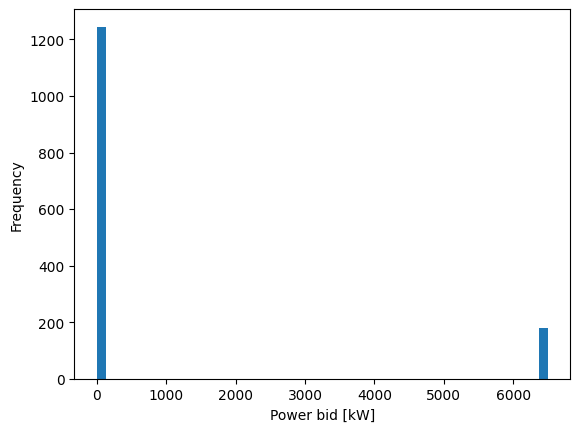

In [ ]:
# Create decision tree classifier
from sklearn.tree import DecisionTreeClassifier

# Create decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)

# Make predictions
y_clf = clf.predict(x_test)
accuracy = np.mean(y_clf == y_test)
print(f"Accuracy: %.2f" % accuracy)

# Calculate revenue
test_data = inputdata[inputdata.index.isin(y_test.index)]
lambda_DA = test_data['spotprice']
lambda_up = test_data['lambda_up']
lambda_down = test_data['lambda_down']
real = test_data["power"]
y = test_data['opt_bids']

revenue_perfect = np.sum(y * lambda_DA + lambda_down * np.maximum(real - y, 0) - lambda_up * np.maximum(y - real, 0))
revenue_clf = np.sum(6500 * y_clf * lambda_DA + lambda_down * np.maximum(real - 6500*y_clf, 0)
                                              - lambda_up * np.maximum(6500*y_clf - real, 0))

print(f"Perfect revenue: %.2f MDKK" % (revenue_perfect/1E9))
print(f"Predicted revenue using decision tree: %.2f MDKK" % (revenue_clf/1E9))

# print difference
print(f"Difference in revenue: %.2f MDKK" % ((revenue_perfect - revenue_clf)/1E9)) 

# Plot histogram of predicted bids
plt.hist(6500*y_clf, bins=50)
plt.xlabel('Power bid [kW]')
plt.ylabel('Frequency')
plt.show()

# Add perfect revenue and revenue from classification to revenues dataframe
revenues['Perfect'] = revenue_perfect
revenues['Decision_tree'] = revenue_clf

An alternative model is using KNN. Here we tune the number of neighbors, fit the model, and plot the distribution of the bids

Accuracy: 0.71
Predicted revenue using k-nearest neighbors: 1.787 MDKK


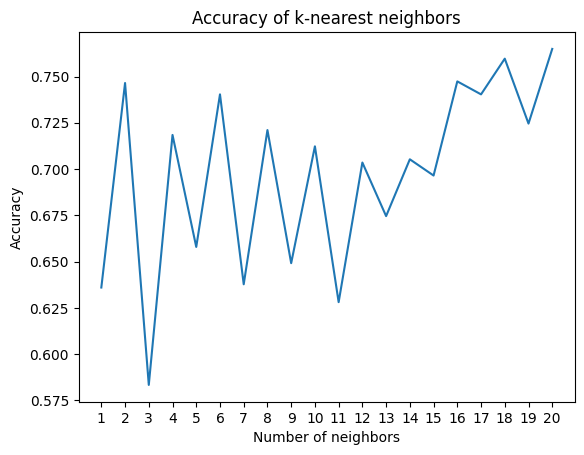

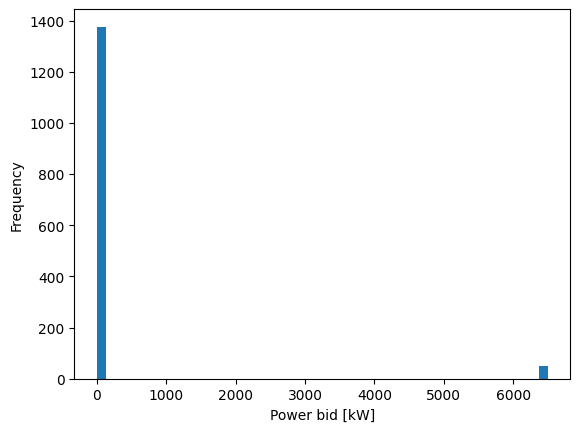

In [70]:
# Try with k-nearest neighbors
from sklearn.neighbors import KNeighborsClassifier

# Determine optimal number of neighbors
neighbors = np.arange(1, 21)
accuracy = np.zeros(len(neighbors))

for i, n in enumerate(neighbors):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(x_train_train, y_train_train)
    y_knn = knn.predict(x_train_val)
    accuracy[i] = np.mean(y_knn == y_train_val)

# Find optimal number of neighbors
opt_k = neighbors[np.argmax(accuracy)]

# Create k-nearest neighbors classifier
knn = KNeighborsClassifier(n_neighbors=opt_k)
knn.fit(x_train, y_train)

# Make predictions
y_knn = knn.predict(x_test)

# Calculate revenue
revenue_knn = np.sum(6500 * y_knn * lambda_DA + lambda_down * np.maximum(real - 6500*y_knn, 0)
                                              - lambda_up * np.maximum(6500*y_knn - real, 0))
revenues['k-nearest neighbors'] = revenue_knn

print(f"Accuracy: %.2f" % np.mean(y_knn == y_test))
print(f"Predicted revenue using k-nearest neighbors: %.3f MDKK" % (revenue_knn/1E9))

# Plot accuracy of k-nearest neighbors
plt.plot(neighbors, accuracy)
plt.xlabel('Number of neighbors')
plt.xticks(neighbors)
plt.ylabel('Accuracy')
plt.title('Accuracy of k-nearest neighbors')
plt.show()

# Plot historgram of bids
plt.hist(6500*y_knn, bins=50)
plt.xlabel('Power bid [kW]')
plt.ylabel('Frequency')
plt.show()

We can also try with an OLS model. We often face a (near) singular matrix in the closed form. Gradient descent is used instead

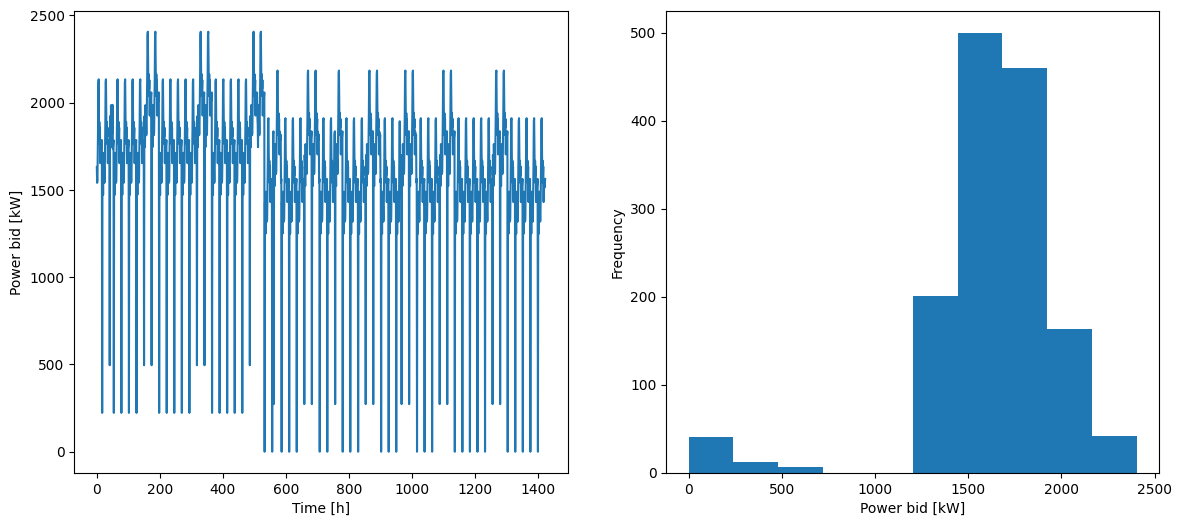

In [71]:
# Fit OLS
y = inputdata['opt_bids']
y_train, y_test = y[:split_index_test], y[split_index_test:]
theta_grad = gradient_descent(x_train, y_train, alpha=0.8)

# Make predictions and ensure that the power bid is non-negative
y_ols = theta_grad @ x_test.T
y_ols = np.maximum(y_ols, 0)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(np.arange(len(y_ols)), y_ols)
ax[0].set_xlabel('Time [h]')
ax[0].set_ylabel('Power bid [kW]')

ax[1].hist(y_ols.values)
ax[1].set_xlabel('Power bid [kW]')
ax[1].set_ylabel('Frequency')
plt.show()

In [253]:
revenue_ols = np.sum(y_ols * lambda_DA + lambda_down * np.maximum(real - y_ols, 0)
                                       - lambda_up * np.maximum(y_ols - real, 0))
print(f"Revenue OLS: %.3f MDKK" % (revenue_ols/1E9))

# Add OLS revenue to revenues dataframe
revenues['OLS_bids'] = revenue_ols

Revenue OLS: 1.852 MDKK


Finally, we can compare the different revenues from the models to see which performs the best when generalized

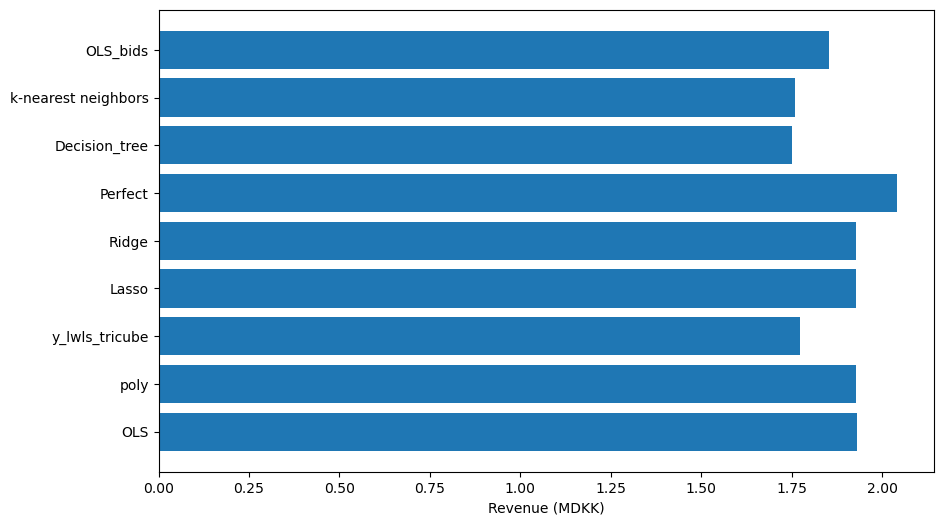

,OLS,poly,y_lwls_tricube,Lasso,Ridge,Perfect,Decision_tree,k-nearest neighbors,OLS_bids
1,1.932,1.929,1.773,1.927,1.929,2.041,1.752,1.761,1.852


In [254]:
# Plot revenue for perfect and predicted bids from both classification and regression
plt.figure(figsize=(10, 6))
plt.barh(revenues.columns, revenues.values[0]/1E9)
plt.xlabel('Revenue (MDKK)')
# plt.title('Revenue for perfect and predicted bids')
plt.show()

# Show revenues based on different models
(revenues/1E9).round(3)